## Arizona Poll Prediction for Remaining Votes by Bayesian Inference ##
#### Will Arizona flip? with less than 80K votes remaining to be counted and the Biden's lead keeps falling, what would be the final outcome? ####

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from pymc3 import  *
import theano
import pandas as pd
from statsmodels.formula.api import glm as glm_sm
import statsmodels.api as sm
from pandas.plotting import scatter_matrix

az.style.use('arviz-darkgrid')

In [3]:
df = np.genfromtxt('./data/arizona-trend.csv', delimiter=',')

In [5]:
#column # lead and #2 To be counted
df[:5,:5]

array([[ 16985.,  81209.],
       [ 16952.,  81536.],
       [ 20102.,  98275.],
       [ 20102., 110925.],
       [ 19348., 117787.]])

In [ ]:
y = df[:50,0]
X = df[:50,1]

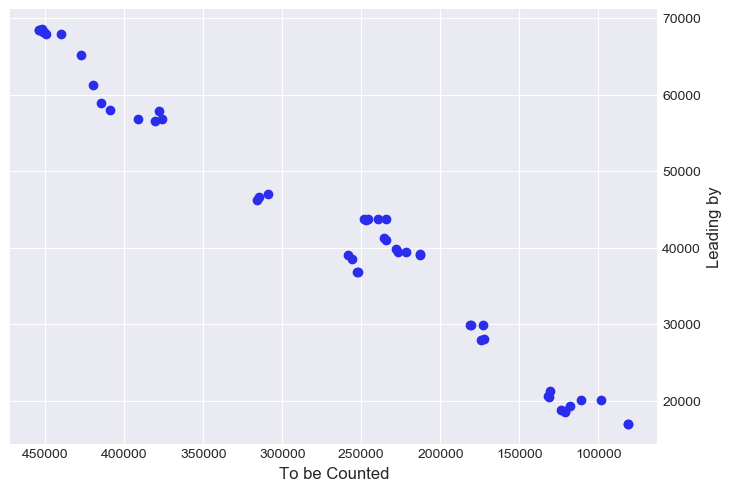

In [29]:
fig, ax = plt.subplots()
plt.scatter(X, y)
#reverse the axis for better readability
ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")
ax.invert_xaxis()
plt.xlabel('To be Counted',fontsize=12)
plt.ylabel('Leading by',fontsize=12)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)


In [23]:
#we just need top 50 to minimize noise/outliers
Y = df[:50,0]
X = df[:50,1]
with Model() as basic_model:
    #initial values, sigma less than 200 is not accepted by the funtion!
    sd=300
    mu=0
    # Priors for unknown model parameters
    intercept = Normal('intercept', mu=mu, sigma=sd)
    beta = Normal('beta', mu=mu, sigma=sd)
    sigma = HalfNormal('sigma', sigma=sd)

    # Expected value of outcome
    mu = intercept + beta*X 

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

In [24]:
with basic_model:
    # draw 2000 posterior samples
    trace = sample(2000, tune=2000,)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, intercept]
Sampling 2 chains, 0 divergences: 100%|███████| 8000/8000 [00:12<00:00, 638.99draws/s]


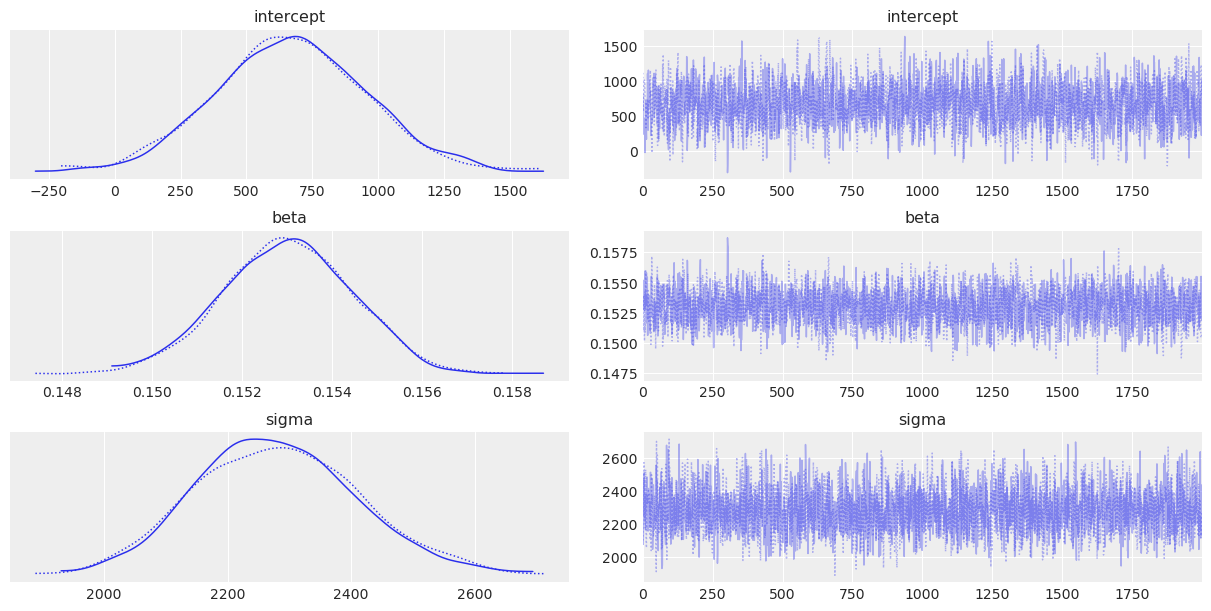

In [25]:
with basic_model:
    traceplot(trace)

In [29]:
#sd=300
az.summary(trace, round_to=2)

C:\Users\Siva\Anaconda3\envs\stan\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,668.43,290.26,138.99,1234.73,6.34,4.48,2098.83,2098.83,2097.37,2695.21,1.0
beta,0.15,0.00,0.15,0.16,0.00,0.00,2316.08,2315.30,2321.43,2817.74,1.0
sigma,2279.53,131.25,2028.86,2521.39,2.48,1.76,2795.93,2795.93,2790.43,2527.39,1.0


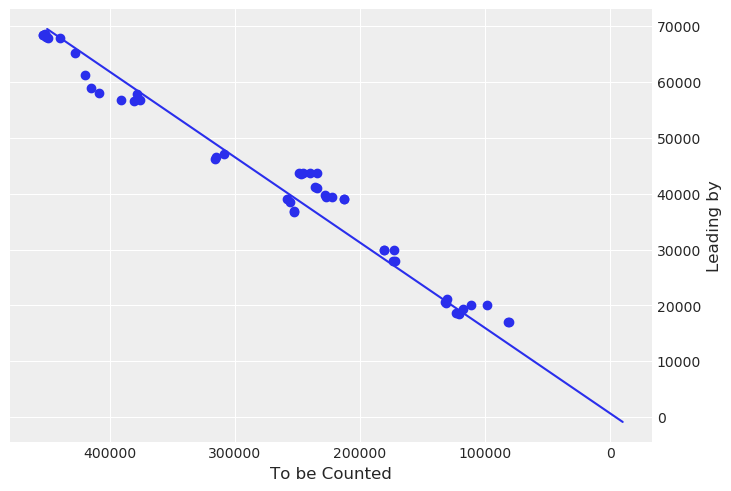

In [27]:
#let's draw the regressionl line beyond 0 to be counted for better readability
x1=np.asarray([450000.,300000.,100000.,0.,-10000])
#predict the y values
y_preds = trace['beta'].mean()*(x1) + trace['intercept'].mean()

fig, ax = plt.subplots()
plt.plot(x1, y_preds)
plt.scatter(X, Y)
ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")
ax.invert_xaxis()
plt.xlabel('To be Counted',fontsize=12)
plt.ylabel('Leading by',fontsize=12)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)

In [41]:
with basic_model:
    ppc = sample_posterior_predictive(
        trace, var_names=["intercept", "beta", "Y_obs"]
    )

100%|████████████████████████████████████████████| 4000/4000 [00:04<00:00, 807.35it/s]


C:\Users\Siva\Anaconda3\envs\stan\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\Siva\Anaconda3\envs\stan\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


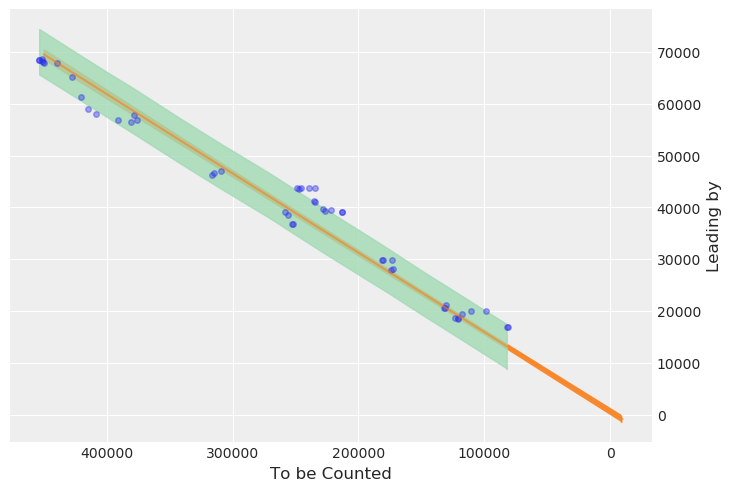

In [57]:
#let's draw the regressionl line beyond 0 to be counted for better readability
X1=np.asarray([450000.,300000.,100000.,0.,-10000])
mu_pp = (ppc["intercept"] + ppc["beta"] * X1[:, None]).T

fig,ax = plt.subplots()

ax.plot(X, Y, "o", ms=4, alpha=0.4, label="Data")
ax.plot(X1, mu_pp.mean(0), label="Mean outcome", alpha=0.6)
az.plot_hpd(
    X1,
    mu_pp,
    ax=ax,
    fill_kwargs={"alpha": 0.8, "label": "Mean outcome 94% HPD"},
)
az.plot_hpd(
    X,
    ppc["Y_obs"],
    ax=ax,
    fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Outcome 94% HPD"},
)

ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")
ax.invert_xaxis()
plt.xlabel('To be Counted',fontsize=12)
plt.ylabel('Leading by',fontsize=12)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)

C:\Users\Siva\Anaconda3\envs\stan\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Siva\Anaconda3\envs\stan\lib\site-packages\seaborn\axisgrid.py:1629: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  f.tight_layout()


<Figure size 900x700 with 0 Axes>

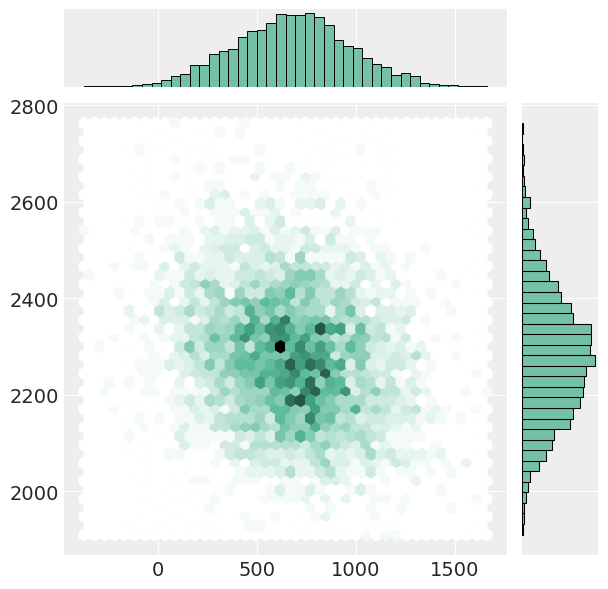

In [14]:
import seaborn as sns
plt.figure(figsize=(9,7))
sns.jointplot(trace['intercept'], trace['sigma'], kind="hex", color="#4CB391")
plt.xlabel("intercept")
plt.ylabel("sigma");
plt.show()

C:\Users\Siva\Anaconda3\envs\stan\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Siva\Anaconda3\envs\stan\lib\site-packages\seaborn\axisgrid.py:1629: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  f.tight_layout()


<Figure size 900x700 with 0 Axes>

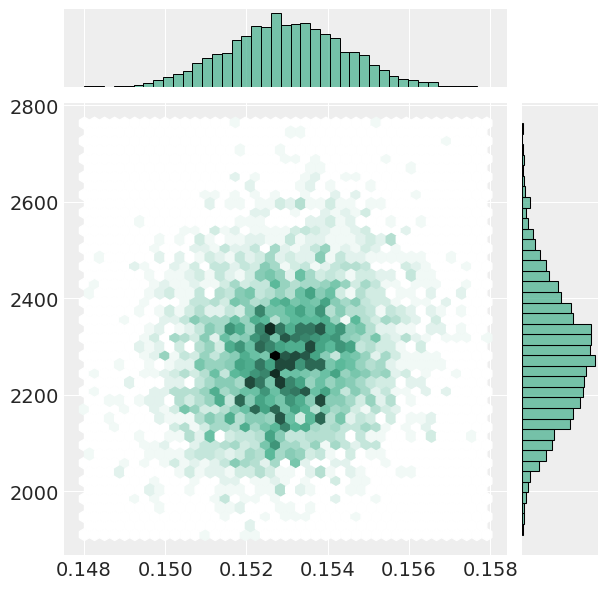

In [15]:
plt.figure(figsize=(9,7))
sns.jointplot(trace['beta'], trace['sigma'], kind="hex", color="#4CB391")
plt.xlabel("beta")
plt.ylabel("sigma");
plt.show()